In [ ]:
!pip install xgboost shap lime scikit-learn pandas numpy matplotlib seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b393ce2ee03209371a71853f4025dc33a639fe6d3d178d4540f0e216da00b81a
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, classification_report, roc_curve
)

# XGBoost
from xgboost import XGBClassifier

# Explainability
import shap
from lime.lime_tabular import LimeTabularExplainer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

input_path = "/content/drive/My Drive/Colab Notebooks/NFRF ML/Final_ITD.csv"

df = pd.read_csv(input_path)
print(df.shape)
df.head()

Mounted at /content/drive
(29880, 38)


,employee_seniority_years,is_contractor,employee_classification,has_foreign_citizenship,has_criminal_record,has_medical_history,risk_travel_indicator,num_print_commands,total_printed_pages,num_print_commands_off_hours,...,num_entries,num_exits,total_presence_minutes,entered_during_night_hours,num_unique_campus,early_entry_flag,entry_during_weekend,first_entry_minutes,last_exit_minutes,is_emp_malicious
0,0.547490,-0.375706,-0.048271,-0.477401,-0.198891,-0.436447,-0.008182,-0.592447,-0.347391,-0.172272,...,-0.999648,-0.999648,-1.187573,-0.039692,-1.069308,-0.069831,-0.29653,-0.114514,-0.181596,1
1,-0.653307,2.661657,-1.388731,-0.477401,5.027891,-0.436447,-0.008182,-0.592447,-0.347391,-0.172272,...,1.392878,1.392878,0.426682,-0.039692,0.481181,-0.069831,-0.29653,-0.159694,-0.993543,0
2,-1.320417,-0.375706,-0.048271,2.094676,-0.198891,-0.436447,-0.008182,1.381759,2.387795,-0.172272,...,1.392878,1.392878,0.564441,-0.039692,0.481181,-0.069831,-0.29653,-0.498547,-0.741181,1
3,0.013802,-0.375706,1.292189,-0.477401,-0.198891,-0.436447,-0.008182,0.197236,-0.098737,-0.172272,...,-0.999648,-0.999648,-1.187573,-0.039692,-1.069308,-0.069831,-0.29653,-0.114514,-0.181596,0
4,0.013802,-0.375706,-1.388731,-0.477401,-0.198891,2.291231,-0.008182,1.381759,0.100185,-0.172272,...,0.196615,0.196615,0.726926,-0.039692,0.481181,-0.069831,-0.29653,-0.769629,-0.357152,0


In [ ]:
X = df.drop(columns=["is_emp_malicious"])   # Change if target name differs
y = df["is_emp_malicious"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

param_grid = {
    "n_estimators": [100, 200, 300],
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1, 0.2],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "gamma": [0, 0.1, 0.2]
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:37:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
y_pred = best_xgb.predict(X_test)
y_prob = best_xgb.predict_proba(X_test)[:, 1]

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_prob)

print("Performance Metrics")
print(f"Accuracy  : {accuracy:.4f}")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-score  : {f1:.4f}")
print(f"ROC-AUC   : {roc_auc:.4f}")

print("\nClassification Report")
print(classification_report(y_test, y_pred))


Performance Metrics
Accuracy  : 0.8944
Precision : 0.8888
Recall    : 0.9016
F1-score  : 0.8952
ROC-AUC   : 0.9691

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.89      0.89      2988
           1       0.89      0.90      0.90      2988

    accuracy                           0.89      5976
   macro avg       0.89      0.89      0.89      5976
weighted avg       0.89      0.89      0.89      5976



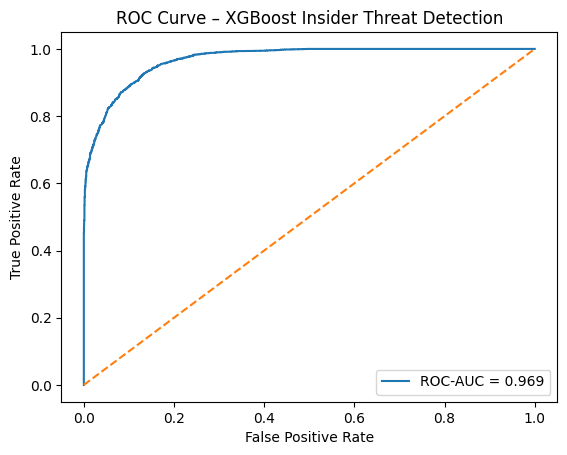

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – XGBoost Insider Threat Detection")
plt.legend()
plt.show()

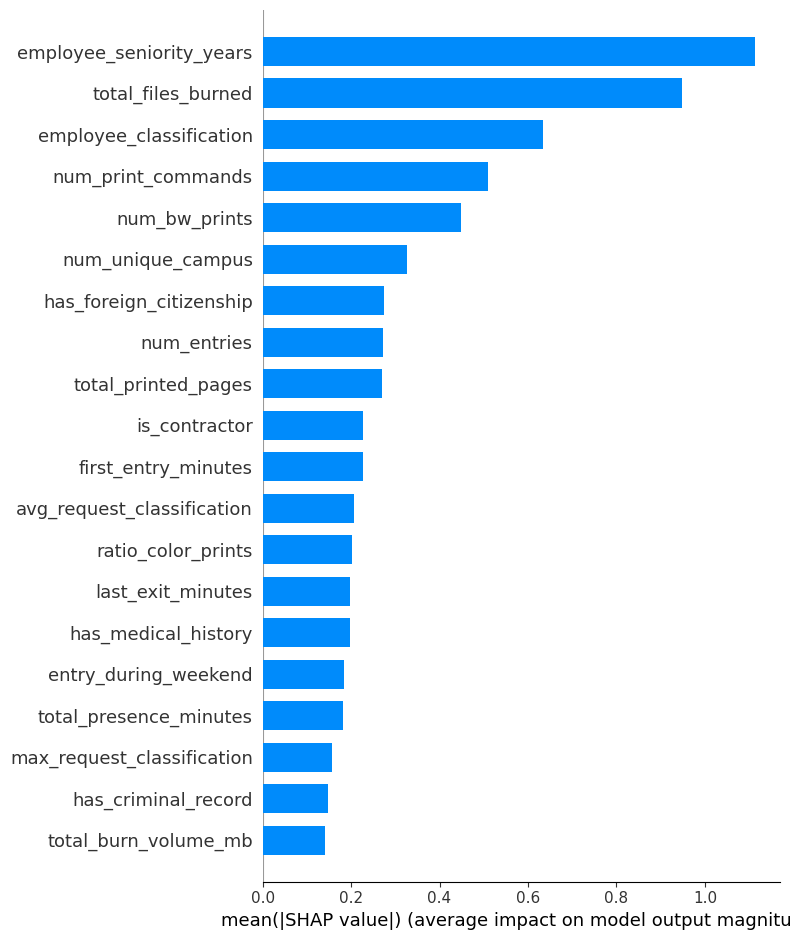

In [ ]:
explainer = shap.TreeExplainer(best_xgb)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, plot_type="bar")

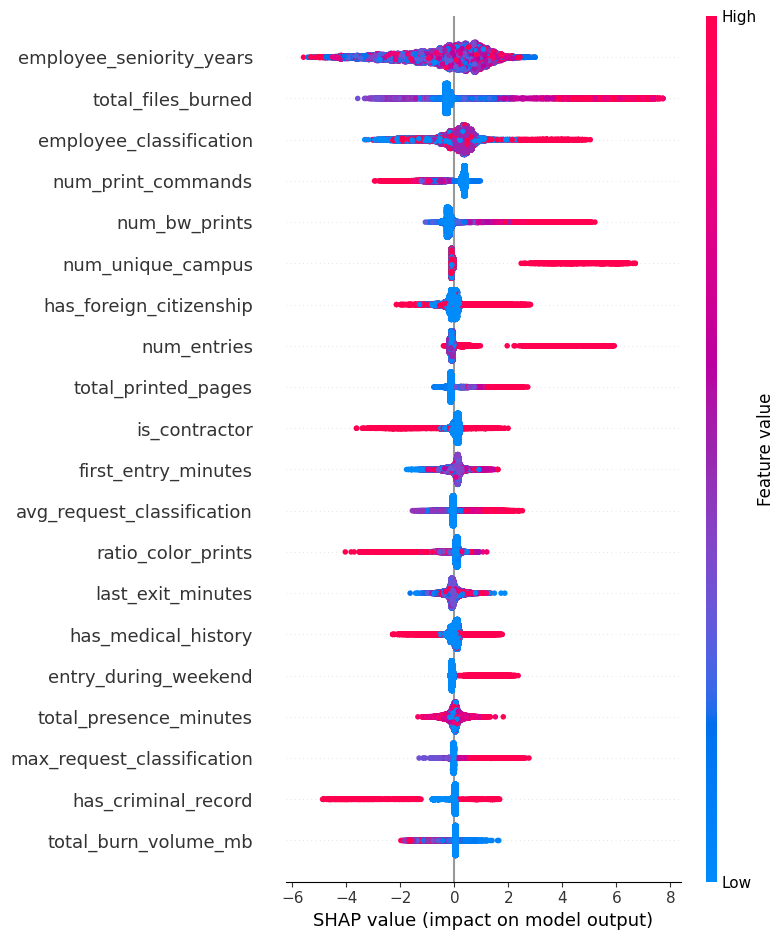

In [ ]:
shap.summary_plot(shap_values, X_train)

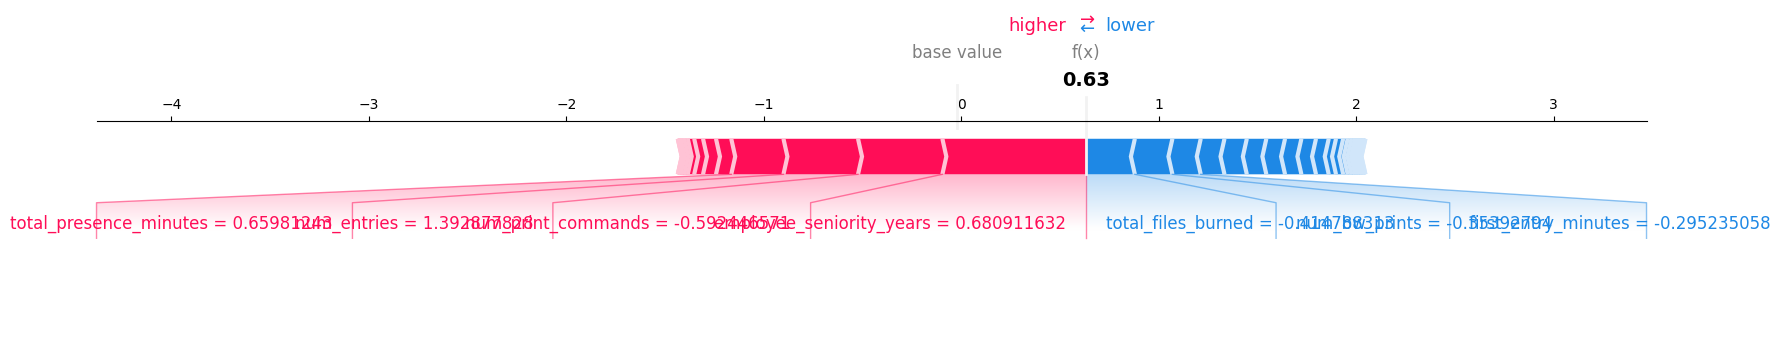

In [ ]:
idx = 5  # change instance index if needed

shap.force_plot(
    explainer.expected_value,
    shap_values[idx],
    X_train.iloc[idx],
    matplotlib=True
)

In [ ]:
lime_explainer = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns.tolist(),
    class_names=["Normal", "Insider Threat"],
    mode="classification"
)

i = 3  # instance index
lime_exp = lime_explainer.explain_instance(
    X_test.iloc[i].values,
    best_xgb.predict_proba,
    num_features=10
)

lime_exp.show_in_notebook(show_table=True)